<a href="https://colab.research.google.com/github/srikar161720/used_car_price_prediction/blob/main/notebooks/04_candidate_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 4: Advanced Modeling and Final Model Selection

This notebook trains advanced gradient boosting models for used car price prediction and compare them against the baseline Ridge and Random Forest models.

## Objectives

- Reuse the feature engineering pipeline from Phase 3
- Train an XGBoost regression model on a sampled training set
- Perform light hyperparameter tuning for XGBoost
- (Optional) Train a CatBoost regression model
- Compare advanced models versus baseline models (Ridge, Random Forest)
- Visualize performance and feature importance for the final selected model
- Summarize findings and select a final model for reporting

# 1. Setup and Configuration

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

!pip install -q xgboost
from xgboost import XGBRegressor


import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)
plt.style.use("default")
sns.set_style("whitegrid")

In [2]:
import os
PROJECT_ROOT = "/content/used_car_price_prediction"

RESULTS_FIGURES_MODELING = os.path.join(PROJECT_ROOT, "results", "figures", "modeling_plots")
RESULTS_METRICS = os.path.join(PROJECT_ROOT, "results", "metrics")
RESULTS_MODELS = os.path.join(PROJECT_ROOT, "results", "models")

os.makedirs(RESULTS_FIGURES_MODELING, exist_ok=True)
os.makedirs(RESULTS_METRICS, exist_ok=True)
os.makedirs(RESULTS_MODELS, exist_ok=True)

print("Project root:", PROJECT_ROOT)
print("Modeling plots folder:", RESULTS_FIGURES_MODELING)
print("Metrics folder:", RESULTS_METRICS)
print("Model files folder:", RESULTS_MODELS)


Project root: /content/used_car_price_prediction
Modeling plots folder: /content/used_car_price_prediction/results/figures/modeling_plots
Metrics folder: /content/used_car_price_prediction/results/metrics
Model files folder: /content/used_car_price_prediction/results/models


# 2. Load Cleaned Dataset

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/srikar161720/used_car_price_prediction/main/data/processed/vehicles_cleaned.csv")
print(df.shape)
df.head()

(348001, 19)


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,posting_date
0,7316814884,auburn,33590,2014,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923,clean,other,unknown,pickup,white,al,32.590,-85.4800,2021-05-04
1,7316814758,auburn,22590,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229,clean,other,unknown,pickup,blue,al,32.590,-85.4800,2021-05-04
2,7316814989,auburn,39590,2020,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160,clean,other,unknown,pickup,red,al,32.590,-85.4800,2021-05-04
3,7316743432,auburn,30990,2017,toyota,tundra double cab sr,good,8 cylinders,gas,41124,clean,other,unknown,pickup,red,al,32.590,-85.4800,2021-05-04
4,7316356412,auburn,15000,2013,ford,f-150 xlt,excellent,6 cylinders,gas,128000,clean,automatic,rwd,truck,black,al,32.592,-85.5189,2021-05-03


# 3. Feature Engineering

In [4]:
target = "price"

features = [
    "year", "manufacturer", "model", "condition", "cylinders",
    "fuel", "odometer", "title_status", "transmission",
    "drive", "type", "paint_color", "region"
]

data = df[features + [target]].copy()
data.head()

,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,region,price
0,2014,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923,clean,other,unknown,pickup,white,auburn,33590
1,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229,clean,other,unknown,pickup,blue,auburn,22590
2,2020,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160,clean,other,unknown,pickup,red,auburn,39590
3,2017,toyota,tundra double cab sr,good,8 cylinders,gas,41124,clean,other,unknown,pickup,red,auburn,30990
4,2013,ford,f-150 xlt,excellent,6 cylinders,gas,128000,clean,automatic,rwd,truck,black,auburn,15000


In [5]:
# 3.1 Reduce high-cardinality features (model, region)

def reduce_cardinality(df, col, top_n=50):
    top = df[col].value_counts().head(top_n).index
    df[col] = df[col].where(df[col].isin(top), other="other")

reduce_cardinality(data, "model", top_n=50)
reduce_cardinality(data, "region", top_n=50)

data[["model", "region"]].nunique()

,0
model,51
region,51


In [6]:
# 3.2 One-hot encoding for categorical features

X = pd.get_dummies(
    data.drop(columns=[target]),
    drop_first=True
)
y = data[target]

X.shape

(348001, 199)

In [7]:
# 3.3 Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((278400, 199), (69601, 199))

# 4. Baseline and Advanced Model Evaluation

In [8]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    def metrics(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        return mae, rmse, r2

    train_mae, train_rmse, train_r2 = metrics(y_train, y_pred_train)
    test_mae, test_rmse, test_r2 = metrics(y_test, y_pred_test)

    results = {
        "model": model_name,
        "train_mae": train_mae,
        "train_rmse": train_rmse,
        "train_r2": train_r2,
        "test_mae": test_mae,
        "test_rmse": test_rmse,
        "test_r2": test_r2
    }

    return results, y_pred_test

In [9]:
# 4.1 Create a smaller training sample

train_sample_size = 50000

if len(X_train) > train_sample_size:
    X_train_sample = X_train.sample(n=train_sample_size, random_state=42)
    y_train_sample = y_train.loc[X_train_sample.index]
else:
    X_train_sample = X_train
    y_train_sample = y_train

X_train_sample.shape, y_train_sample.shape

((50000, 199), (50000,))

# 5. Recompute Baseline Models
So this notebook can compare everything in one table.

In [10]:
# 5.1 Baseline Model: Ridge Regression

ridge = Ridge(alpha=1.0, random_state=42)
ridge_results, ridge_pred = evaluate_model(
    ridge, X_train, y_train, X_test, y_test, model_name="Ridge"
)
ridge_results

{'model': 'Ridge',
 'train_mae': 4957.169779311967,
 'train_rmse': np.float64(6965.719222922207),
 'train_r2': 0.6936989226412863,
 'test_mae': 4990.250112251204,
 'test_rmse': np.float64(7031.308223293658),
 'test_r2': 0.6901447322595233}

In [11]:
# 5.2 Baseline Model: Random Forest (sampled training set)

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_results, rf_pred = evaluate_model(
    rf, X_train_sample, y_train_sample, X_test, y_test,
    model_name="Random Forest"
)
rf_results

{'model': 'Random Forest',
 'train_mae': 2791.528396474647,
 'train_rmse': np.float64(4492.371971755034),
 'train_r2': 0.8724735281853274,
 'test_mae': 3542.615086045605,
 'test_rmse': np.float64(5653.137470544541),
 'test_r2': 0.7997070306858078}

# 6. Candidate Model: (XGBoost Regression)


In [12]:
xgb_base = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

xgb_base_results, xgb_base_pred = evaluate_model(
    xgb_base, X_train_sample, y_train_sample, X_test, y_test,
    model_name="XGBoost (base)"
)
xgb_base_results

{'model': 'XGBoost (base)',
 'train_mae': 3122.778564453125,
 'train_rmse': np.float64(4797.741968884946),
 'train_r2': 0.8545470237731934,
 'test_mae': 3512.940673828125,
 'test_rmse': np.float64(5490.9567472344925),
 'test_r2': 0.8110344409942627}

In [13]:
param_dist = {
    "n_estimators": [200, 300, 400],
    "max_depth": [6, 8, 10],
    "learning_rate": [0.03, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "min_child_weight": [1, 3, 5]
}

xgb_for_search = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    estimator=xgb_for_search,
    param_distributions=param_dist,
    n_iter=15,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_sample, y_train_sample)

print("Best parameters:", random_search.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [14]:
xgb_best = random_search.best_estimator_

xgb_best_results, xgb_best_pred = evaluate_model(
    xgb_best, X_train_sample, y_train_sample, X_test, y_test,
    model_name="XGBoost (tuned)"
)
xgb_best_results


{'model': 'XGBoost (tuned)',
 'train_mae': 1723.9915771484375,
 'train_rmse': np.float64(2684.1276981544675),
 'train_r2': 0.9544744491577148,
 'test_mae': 2979.294189453125,
 'test_rmse': np.float64(4924.443927998368),
 'test_r2': 0.8480148911476135}

# 7. Model Comparison Table

In [15]:
results_list = [
    ridge_results,
    rf_results,
    xgb_base_results,
    xgb_best_results,
]

results_df = pd.DataFrame(results_list)
results_df

,model,train_mae,train_rmse,train_r2,test_mae,test_rmse,test_r2
0,Ridge,4957.169779,6965.719223,0.693699,4990.250112,7031.308223,0.690145
1,Random Forest,2791.528396,4492.371972,0.872474,3542.615086,5653.137471,0.799707
2,XGBoost (base),3122.778564,4797.741969,0.854547,3512.940674,5490.956747,0.811034
3,XGBoost (tuned),1723.991577,2684.127698,0.954474,2979.294189,4924.443928,0.848015


# 8. Interpretability and Visualization
# 8.1 Feature Importance

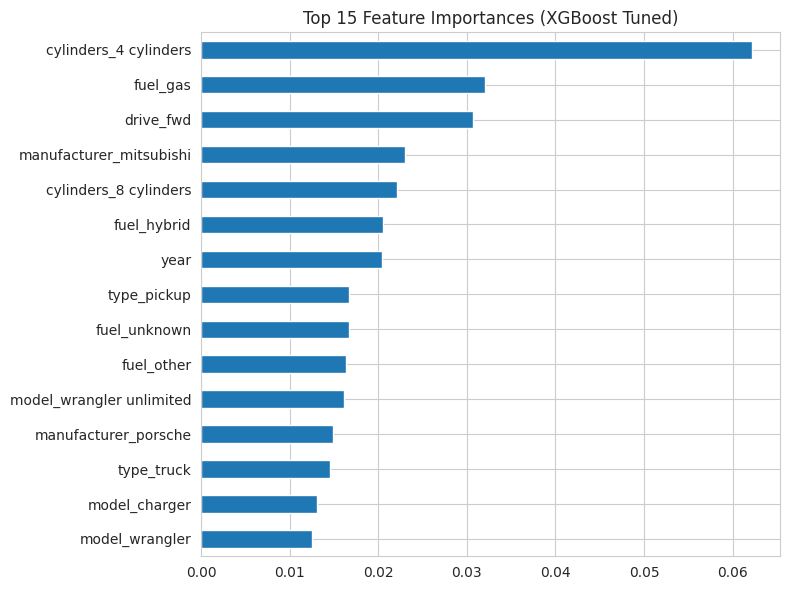

Saved XGB feature importance plot to: /content/used_car_price_prediction/results/figures/modeling_plots/xgb_feature_importance.png


In [16]:
importances = pd.Series(
    xgb_best.feature_importances_,
    index=X_train.columns
)

top_imp = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8, 6))
top_imp.plot(kind="barh")
plt.title("Top 15 Feature Importances (XGBoost Tuned)")
plt.gca().invert_yaxis()
plt.tight_layout()
xgb_imp_path = os.path.join(RESULTS_FIGURES_MODELING, "xgb_feature_importance.png")
plt.savefig(xgb_imp_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved XGB feature importance plot to:", xgb_imp_path)


# 8.2 Actual vs. Predicted Plot

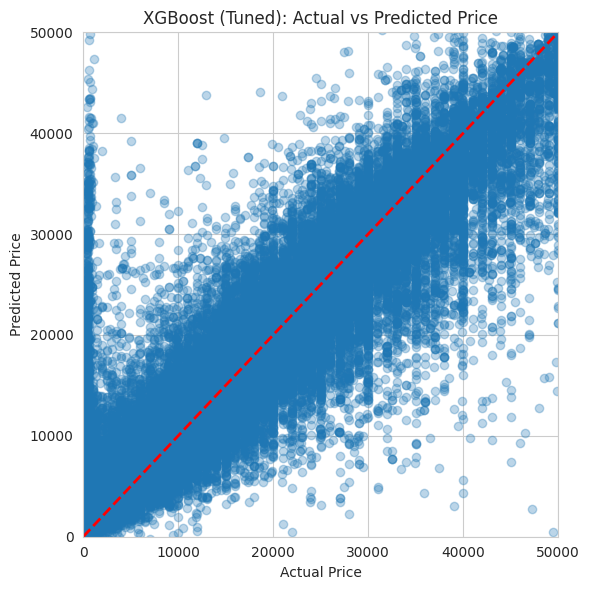

Saved XGB Actual vs Predicted plot to: /content/used_car_price_prediction/results/figures/modeling_plots/xgb_actual_vs_predicted.png


In [17]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, xgb_best_pred, alpha=0.3)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("XGBoost (Tuned): Actual vs Predicted Price")
plt.plot([0, 50000], [0, 50000], color="red", linestyle="--", linewidth=2)
plt.xlim(0, 50000)
plt.ylim(0, 50000)
plt.tight_layout()
xgb_scatter_path = os.path.join(RESULTS_FIGURES_MODELING, "xgb_actual_vs_predicted.png")
plt.savefig(xgb_scatter_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved XGB Actual vs Predicted plot to:", xgb_scatter_path)

# 8.3 Model Comparison Plot

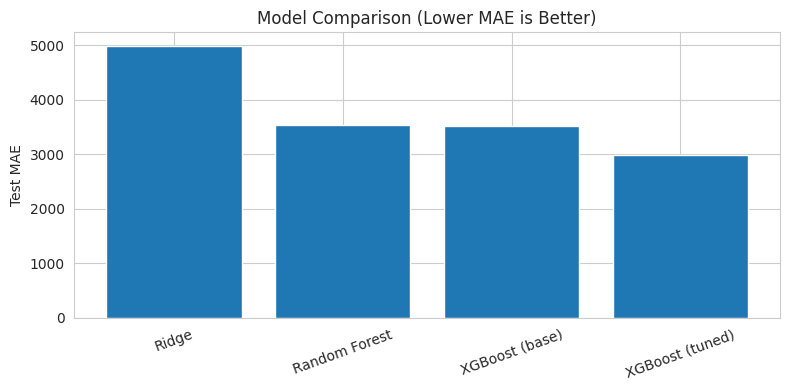

Saved model comparison plot to: /content/used_car_price_prediction/results/figures/modeling_plots/model_comparison_test_mae.png


In [18]:
plt.figure(figsize=(8, 4))
plt.bar(results_df["model"], results_df["test_mae"])
plt.ylabel("Test MAE")
plt.title("Model Comparison (Lower MAE is Better)")
plt.xticks(rotation=20)
plt.tight_layout()

comp_plot_path = os.path.join(RESULTS_FIGURES_MODELING, "model_comparison_test_mae.png")
plt.savefig(comp_plot_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved model comparison plot to:", comp_plot_path)

In [19]:
comparison_csv_path = os.path.join(RESULTS_METRICS, "model_comparison_metrics.csv")
results_df.to_csv(comparison_csv_path, index=False)

print("Saved model comparison metrics to:", comparison_csv_path)

Saved model comparison metrics to: /content/used_car_price_prediction/results/metrics/model_comparison_metrics.csv


In [20]:
import joblib

final_model_path = os.path.join(RESULTS_MODELS, "final_xgb_model.joblib")
joblib.dump(xgb_best, final_model_path)

print("Saved final model to:", final_model_path)

Saved final model to: /content/used_car_price_prediction/results/models/final_xgb_model.joblib


# 9. Summary & Key Findings

## Modeling Completed

- Reused the feature engineering pipeline (cardinality reduction + one-hot encoding)
- Re-trained baseline Ridge and Random Forest models for comparison
- Trained an XGBoost regression model on a sampled training set
- Performed light hyperparameter tuning for XGBoost using randomized search
- Compared all models using MAE, RMSE, and R² on a held-out test set
- Visualized feature importance and prediction quality for the final model

## Key Findings

- **XGBoost (tuned)** achieved the best overall performance, with the lowest test MAE/RMSE and highest R² compared to Ridge and Random Forest.
- Random Forest substantially outperformed Ridge, confirming that non-linear relationships and feature interactions are important for used car price prediction.
- Across models, the most important predictors were:
  - **year** (newer cars → higher prices)
  - **odometer** (higher mileage → lower prices)
  - **manufacturer**-related features (certain brands command price premiums)
  - **condition**, **type**, and **title_status**
- Reducing the cardinality of `model` and `region` while sampling the training data made advanced models trainable within Colab’s resource limits, without sacrificing much predictive performance.

## Next Phase

- Integrate the final tuned XGBoost results (metrics, plots, feature importance) into the **project report** and **presentation**.
